In [1]:
from __future__ import division
%matplotlib nbagg
import os, sys
import numpy as np
import pandas as pd
from collections import defaultdict
from src.python_latexify import latexify, format_axes
latexify()

import matplotlib
matplotlib.rcParams.update(latexify())
import matplotlib.pyplot as plt

#font = {'family' : 'normal',
#        'weight' : 'bold',
#        'size'   : 14}
#matplotlib.rc('font', **font)

In [2]:
from src.censorship_ratios import *

DATA = "data/"
PLOTS = "results/calibration/plots/"
TABLES = "results/calibration/tables/"
if not os.path.exists(PLOTS):
    os.makedirs(PLOTS)
if not os.path.exists(TABLES):
    os.makedirs(TABLES)

## sIP_subcat original

In [3]:
df_sIP_subcat_orig = pd.read_csv("utils/Servers_IMC-original.txt")
df_sIP_subcat_orig['subcat'] = df_sIP_subcat_orig['subcat'].apply(
    lambda x: x.replace('kids_and_teens', 'teens'))

## SANITY CHECK MEASUREMENTS: APR 12 DATA

In [4]:
df_mock = pd.read_pickle(DATA + "case_detected_all_20150412.pkl")
print len(df_mock)

235695


## Remove countries with < 100 measurements

In [5]:
meas_mock = df_mock.groupby('country')['port'].count()
valid_countries = list(meas_mock[meas_mock > 100].index)
print len(valid_countries)

60


In [6]:
df_mock.groupby('country')['port'].count().describe()

count      146.000000
mean      1614.349315
std       5522.959317
min          1.000000
25%         12.250000
50%         65.000000
75%        490.750000
max      35185.000000
Name: port, dtype: float64

In [7]:
df_mock2 = df_mock[ df_mock['country'].isin(valid_countries) ]
print len(df_mock), len(df_mock2)

235695 233346


In [8]:
df_mock2.groupby('country')['port'].count().describe()

count       60.000000
mean      3889.100000
std       8125.918866
min        103.000000
25%        271.500000
50%        825.000000
75%       2025.750000
max      35185.000000
Name: port, dtype: float64

## Remove stray sIP

In [9]:
meas = df_mock2.groupby('sIP')['port'].count()
bad_sIP = list( meas[meas <= 1].index )
print bad_sIP
meas[meas > 1].describe()

['54.255.183.119']


count    473.000000
mean     493.329810
std      121.172857
min      287.000000
25%      401.000000
50%      467.000000
75%      587.000000
max      833.000000
Name: port, dtype: float64

In [10]:
df_sanitized = df_mock2[~df_mock2.sIP.isin(bad_sIP)]
len(df_sanitized)

233345

# CALIBRATION

In [11]:
censorship = get_censorship_by_country_sIP(df_sanitized)['global']
len(censorship)

473

In [12]:
def getCDF(data, CDF=1):
    xdata = np.sort(data)
    if CDF:
        ydata = [i/len(xdata) for i in range(len(xdata))]
    else:
        ydata = [i for i in range(len(xdata))]
    return xdata, ydata

<IPython.core.display.Javascript object>


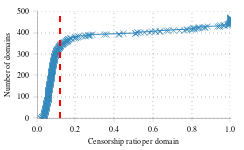

In [13]:
THRESH = 0.12
x, y = getCDF( list( censorship ), 0)
fig1, ax1 = plt.subplots(1,1)
ax1.plot(x, y, marker='x')
ax1.axvline(THRESH, ls='--', color='r', lw=2)
ax1.grid(1)
ax1.set_xlabel("Censorship ratio per domain")
ax1.set_ylabel("Number of domains")
fig1.tight_layout()
format_axes(ax1)

fig1.savefig(PLOTS + "calibrating_sIPs_knee_country_thresh100")
fig1.savefig(PLOTS + "calibrating_sIPs_knee_country_thresh100.pdf")

<IPython.core.display.Javascript object>


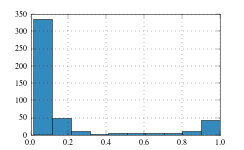

In [14]:
plt.close()
censorship.hist()


<IPython.core.display.Javascript object>


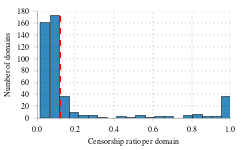

In [30]:
THRESH = 0.12
fig1, ax1 = plt.subplots(1,1)
ax1=censorship.hist(bins=20)
#iax1.plot(x, y, marker='x')
ax1.axvline(THRESH, ls='--', color='r', lw=2)
ax1.grid(1)
ax1.set_xlabel("Censorship ratio per domain")
ax1.set_ylabel("Number of domains")
fig1.tight_layout()
format_axes(ax1)

fig1.savefig(PLOTS + "Hist_calibrating_sIPs_knee_country_thresh100")
fig1.savefig(PLOTS + "Hist_calibrating_sIPs_knee_country_thresh100.pdf")

### Greater than 12% censorship at the knee

In [15]:
THRESH = 0.12

In [16]:
bad_sIP = list(censorship[censorship > THRESH].reset_index()['sIP'])
good_sIP = list(censorship[censorship <= THRESH].reset_index()['sIP'])
print len(bad_sIP), len(good_sIP)

128 345


In [17]:
df_sanitized2 = df_sanitized[df_sanitized['sIP'].isin(good_sIP) 
                             | (df_sanitized['domain'].isin(['torDir'])) ]
print len(df_sanitized2), len(df_sanitized2['sIP'].unique())

165691 345


### ONLY KEEP good_sIPs and ADD torDir NOW

In [19]:
df_sIP_subcat_calibrated = df_sIP_subcat_orig[(df_sIP_subcat_orig['sIP'].isin(good_sIP)) 
                                              | (df_sIP_subcat_orig['domain'].isin(['torDir'])) ]
print "TOTAL DOMAINS IN TEST LIST AFTER CALIBRATION = ", len(df_sIP_subcat_calibrated)

TOTAL DOMAINS IN TEST LIST AFTER CALIBRATION =  351


# SAVE UPDATED SUBCATS

In [20]:
subcat_duplicated = defaultdict(list)
for ix, row in df_sIP_subcat_calibrated.iterrows():
    if len(row[2].split("|"))>1:
        shared = 1
    else:
        shared = 0
    for subcat in row[2].split("|"):
        if subcat == 'kids_and_teens':
            subcat = 'teens'
        subcat_duplicated['sIP'].append(row[0])
        subcat_duplicated['domain'].append(row[1])
        subcat_duplicated['subcat'].append(subcat)
        subcat_duplicated['shared'].append(shared)
df_sIP_subcat_disjoint = pd.DataFrame(subcat_duplicated)

In [21]:
df_sIP_subcat_calibrated.to_csv("utils/Servers_IMC-calibrated.txt", index=False)
df_sIP_subcat_disjoint.to_csv("utils/Servers_IMC-disjoint.txt", index=False)

good_sIP = list(df_sIP_subcat_calibrated['sIP'])

#-----------------------------------------------------------------------------------------------------------

# DATASET STATS: COMPARE MEASUREMENT AND CALIBRATION

In [22]:
df_all1 = pd.read_pickle(DATA + "case_detected_all_20150423.pkl")
df_all2 = pd.read_pickle(DATA + "case_detected_all_20150427.pkl")
df_all = pd.concat([df_all1,df_all2])
print len(df_all1), len(df_all2), len(df_all)

250593 146328 396921


In [23]:
del df_all1, df_all2
#del df_mock

In [24]:
df_final = df_all[df_all['sIP'].isin(list(df_sIP_subcat_calibrated['sIP']))]
print len(df_final)

274102


## TABLE: Calibration (df_mock) vs Measurement (df_final)

In [33]:
stats = defaultdict(int)
data = defaultdict(int)
data['calibration'] = df_mock2
data['before'] = df_all
data['measurement'] = df_final

In [34]:
def get_data_stats(df):
    # Totals, errors, cases: groupby(case)
    stats1 = df.groupby('case')['port'].count()
    stats1['total'] = stats1.sum()
    # each case
    stats1['error'] = str( int(stats1[0] + stats1[4]) ) + " (" + "%.2f"%( (stats1[0] + stats1[4])/stats1['total']*100 ) +"%)"
    stats1['case1'] = str( int(stats1[1]) ) + " (" + "%.2f"%( (stats1[1])/stats1['total']*100 ) +"%)"
    stats1['case2'] = str( int(stats1[2]) ) + " (" + "%.2f"%( (stats1[2])/stats1['total']*100 ) +"%)"
    stats1['case3'] = str( int(stats1[3]) ) + " (" + "%.2f"%( (stats1[3])/stats1['total']*100 ) +"%)"
    
    # total measurements
    stats1['measurements'] = len(df)
    
    # SERVER: number of unique sIPs tested to
    stats1['servers'] = len(df['sIP'].unique())
    
    
    # CLIENT: number of countries: countries.unique
    stats1['countries'] = len(df['country'].unique())
    # number of global routers
    stats1['routers'] = len(df['gIP'].unique())
    # number of individual ASNs
    #stats1['ASN'] = len(df['ASN'].unique())
    
    return stats1

In [35]:
for dataset in data.keys():
    df = data[dataset]
    stats[dataset] = get_data_stats(df)

In [41]:
final = pd.concat({'Calibration': stats['calibration'],
                   'Measurement': stats['measurement'],
                  'Meas (no-calib)': stats['before']},
                  axis=1).T.rename(columns={'case1': 'case1 (%)','case2': 'case2 (%)',
                                            'case3': 'case3 (%)', 'error':'unknown (%)'})

In [42]:
final.to_html(TABLES + 'tab1_data_description_country_thresh100.html')

In [43]:
final

case,0,1,2,3,4,total,unknown (%),case1 (%),case2 (%),case3 (%),measurements,servers,countries,routers
Calibration,22221,7451,155817,36397,11460,233346,33681 (14.43%),7451 (3.19%),155817 (66.78%),36397 (15.60%),233346,474,60,20248
Meas (no-calib),25376,15145,305498,36022,14880,396921,40256 (10.14%),15145 (3.82%),305498 (76.97%),36022 (9.08%),396921,519,147,22513
Measurement,16038,7278,235560,4774,10452,274102,26490 (9.66%),7278 (2.66%),235560 (85.94%),4774 (1.74%),274102,331,147,20268


# SAVE CALIBRATED MEASUREMENT

In [44]:
good_calib = df_sanitized[ (df_sanitized['sIP'].isin(good_sIP)) | (df_sanitized['domain'].isin(['torDir'])) ]
bad_calib = df_sanitized[ df_sanitized['sIP'].isin(bad_sIP) & ~(df_sanitized['domain'].isin(['torDir'])) ]

In [45]:
good_calib.to_pickle("data/calibrated_good_server.pkl")
bad_calib.to_pickle("data/calibrated_bad_server.pkl")
df_final.to_pickle("data/measurement_data.pkl")

# See the affect of calibration

<IPython.core.display.Javascript object>


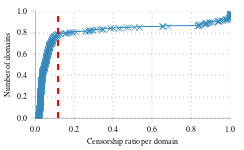

In [46]:
censorship = get_censorship_by_country_sIP(df_all)['global']
THRESH = 0.12

x, y = getCDF( list( censorship ) )
fig1, ax1 = plt.subplots(1,1)
ax1.plot(x, y, marker='x')
ax1.axvline(THRESH, ls='--', color='r', lw=2)
ax1.grid(1)
ax1.set_xlabel("Censorship ratio per domain")
ax1.set_ylabel("Number of domains")
fig1.tight_layout()
format_axes(ax1)

fig1.savefig(PLOTS + "before_calibrating_full_measurement")
fig1.savefig(PLOTS + "before_calibrating_full_measurement.pdf")

### WHAT ESCAPES?

In [47]:
censorship = get_censorship_by_country_sIP(df_final)['global'].copy()
df_cens = pd.DataFrame(censorship).join(df_sIP_subcat_calibrated.set_index('sIP')).sort('global')
df_cens['ydata'] = [i/len(censorship) for i in range(len(censorship))]
THRESH = 0.12

<IPython.core.display.Javascript object>


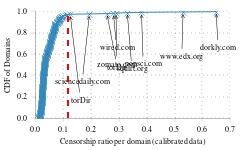

0.126225490196 torDir
0.195148842337 sciencedaily.com
0.25768321513 torDir
0.281105990783 wired.com
0.290721649485 zomato.com
0.330589849108 squirt.org
0.381551362683 popsci.com
0.530666666667 www.edx.org
0.648979591837 dorkly.com


In [51]:
x = df_cens['global']
y = df_cens['ydata']
labels = df_cens['domain']

fig1, ax1 = plt.subplots(1,1)
ax1.plot(x, y, marker='x')
ax1.axvline(THRESH, ls='--', color='r', lw=2)
ax1.grid(1)
ax1.set_xlabel("Censorship ratio per domain (calibrated data)")
ax1.set_ylabel("CDF of Domains")
for label, x, y in zip(labels, x, y):
    if x > THRESH:
        print x, label
        ax1.annotate(
            label, 
            xy = (x, y), xytext = (20, -10*(1/x)-np.random.randint(30)),
            textcoords = 'offset points', ha = 'right', va = 'bottom',
            #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

fig1.tight_layout()
format_axes(ax1)

fig1.savefig(PLOTS + "after_calibrating_full_measurement")
fig1.savefig(PLOTS + "after_calibrating_full_measurement.pdf")

# COMPARE THE DOMAINS THAT ESCAPED: CALIB vs MEAS

In [52]:
censorship = get_censorship_by_country_sIP(df_final)['global'].copy()
df_cens = pd.DataFrame(censorship).join(df_sIP_subcat_orig.set_index('sIP')).sort('global').rename(
    columns= {'global':'meas'} )

In [53]:
censorship_calib = get_censorship_by_country_sIP(df_mock)['global']
df_cens['calib'] = censorship_calib

In [54]:
wierd_sIPs = df_cens[ (df_cens['meas'] > THRESH) & (df_cens['calib'] <= THRESH)]
wierd_sIPs

,meas,domain,subcat,calib
sIP,,,,
54.174.118.57,0.195149,sciencedaily.com,teens|science,0.055838
54.174.139.140,0.281106,wired.com,arts|computers,0.082742
52.74.69.52,0.290722,zomato.com,recreation|regional,0.081206
158.106.84.60,0.330590,squirt.org,adult,0.074074
54.164.68.43,0.381551,popsci.com,teens|science,0.089806
54.163.241.169,0.530667,www.edx.org,reference,0.053824
54.225.210.86,0.648980,dorkly.com,games,0.062954


In [55]:
df1 = good_calib[ good_calib['sIP'].isin(wierd_sIPs.index) ]
df2 = df_final[ df_final['sIP'].isin(wierd_sIPs.index) ]

In [56]:
stats = defaultdict(int)
for sIP in wierd_sIPs.index:
    stats['calib', sIP] = get_data_stats(df1[df1.sIP == sIP])
    stats['meas', sIP] = get_data_stats(df2[df2.sIP == sIP])
df_wierd_sIP_stats = pd.DataFrame(stats).T

In [57]:
df_wierd_sIP_stats['censor'] = (df_wierd_sIP_stats[1]+df_wierd_sIP_stats[3])/df_wierd_sIP_stats['total']

In [59]:
wierd_sIP_final = df_wierd_sIP_stats.reset_index().rename(columns={
        'level_0':'data', 'level_1':'sIP'}).merge(wierd_sIPs.reset_index()[[
            'sIP', 'domain', 'subcat']], on='sIP')
wierd_sIP_final.to_html(TABLES + "wierd_6sIPs_that_changed.html")

# CDF of CENSORSHIP in CALIB and MEAS BY COUNTRY

In [48]:
valid_sIPs = list(df_sIP_subcat_calibrated['sIP'])

In [182]:
# Only 60 countries for valid sIPs
calib = df_sanitized2
meas = df_final[df_final['country'].isin(valid_countries)]

# The rest of 147-60 countries for valid sIPs
calib2 = df_mock[ (df_mock['sIP'].isin(valid_sIPs)) & ~(df_mock['country'].isin(valid_countries))]
meas2 = df_all[ (df_all['sIP'].isin(valid_sIPs)) & ~(df_all['country'].isin(valid_countries))]

calib3 = df_mock[df_mock['sIP'].isin(valid_sIPs)]
meas3 = df_final

In [183]:
cases_calib = get_ratios( calib.groupby(['country','case'])['port'].count().unstack().fillna(0))
cases_meas = get_ratios( meas.groupby(['country','case'])['port'].count().unstack().fillna(0))

ratios1 = pd.DataFrame({ 'calib': 1-cases_calib['case2'], 'meas':  1-cases_meas['case2'] })

In [184]:
cases_calib2 = get_ratios( calib2.groupby(['country','case'])['port'].count().unstack().fillna(0))
cases_meas2 = get_ratios( meas2.groupby(['country','case'])['port'].count().unstack().fillna(0))

ratios2 = pd.DataFrame({ 'calib': 1-cases_calib2['case2'], 'meas':  1-cases_meas2['case2'] })

In [185]:
# ALL 147 countries
cases_calib3 = get_ratios( calib3.groupby(['country','case'])['port'].count().unstack().fillna(0))
cases_meas3 = get_ratios( meas3.groupby(['country','case'])['port'].count().unstack().fillna(0))

ratios3 = pd.DataFrame({ 'calib': 1-cases_calib3['case2'], 'meas':  1-cases_meas3['case2'] })

In [186]:
ratios2['change'] = ratios2['meas']-ratios2['calib']
ratios1['change'] = ratios1['meas']-ratios1['calib']

In [187]:
THRESH = 0.1
ratios1[(ratios1['change'] > THRESH) | (ratios1['change'] < -THRESH)]

,calib,meas,change
country,,,


In [188]:
ratios2[(ratios2['change'] > THRESH) | (ratios2['change'] < -THRESH)]

,calib,meas,change
BJ,0.250000,0.045632,-0.204368
CG,0.000000,0.173238,0.173238
CU,0.333333,0.188850,-0.144484
HN,0.153846,0.047161,-0.106685
KG,0.000000,0.115434,0.115434
LR,1.000000,0.670285,-0.329715
MN,0.200000,0.082320,-0.117680
PG,0.000000,0.445353,0.445353
PY,0.200000,0.024312,-0.175688
TM,0.000000,0.294515,0.294515


<IPython.core.display.Javascript object>


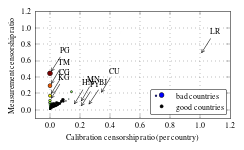

0.25 0.0456323337679 BJ
0.0 0.173237753883 CG
0.333333333333 0.188849824209 CU
0.153846153846 0.0471607314726 HN
0.0 0.115433673469 KG
1.0 0.670284938942 LR
0.2 0.0823199251637 MN
0.0 0.445353159851 PG
0.2 0.0243122200896 PY
0.0 0.294514767932 TM


In [192]:
fig1, ax1 = plt.subplots(1,1)
#ax1.scatter(ratios3['calib'], ratios3['meas'], c='g', marker='.', label='all')
ax1.scatter(ratios2['calib'], ratios2['meas'], c=ratios2['change'], marker='.', s=ratios2['change']*200, label='bad countries')
ax1.scatter(ratios1['calib'], ratios1['meas'], c='k', marker='o', s=ratios1['change']*200, label='good countries')


for label, row in ratios2.iterrows():
    x = row['calib']
    y = row['meas']
    z = row['change']
    
    if ((z > THRESH) or (z < -THRESH)):
        print x, y, label
        ax1.annotate(
            label, 
            xy = (x, y), xytext = (20, 20),
            textcoords = 'offset points', ha = 'right', va = 'bottom',
            #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
        
for label, row in ratios1.iterrows():
    x = row['calib']
    y = row['meas']
    z = row['change']
    
    if ((z > THRESH) or (z < -THRESH)):
        print x, y, label
        ax1.annotate(
            label, 
            xy = (x, y), xytext = (20, 20),
            textcoords = 'offset points', ha = 'right', va = 'bottom',
            #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

ax1.legend(loc=4)
ax1.grid(1)
ax1.set_xlim([-0.1,1.2])
ax1.set_ylim([-0.1,1.2])
ax1.set_xlabel("Calibration censorship ratio (per country)")
ax1.set_ylabel("Measurement censorship ratio")
fig1.tight_layout()
fig1.savefig(PLOTS + "scatter_censorship_ratio_by_country_calib_meas")
fig1.savefig(PLOTS + "scatter_censorship_ratio_by_country_calib_meas.pdf")

In [198]:
def getCDF2(data):
    xdata = np.sort(data)
    ydata = [i for i in range(len(xdata))]
    return xdata, ydata

<IPython.core.display.Javascript object>


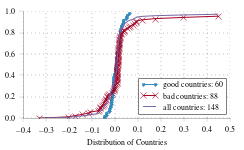

In [203]:
fig1, ax1 = plt.subplots(1,1)

# CDF distribution
x1, y1 = getCDF(ratios['meas']-ratios['calib'])
x2, y2 = getCDF(ratios2['meas']-ratios2['calib'])
x3, y3 = getCDF(ratios3['meas']-ratios3['calib'])

ax1.plot(x1, y1, label='good countries: '+str(len(x1)), marker='.')
ax1.plot(x2, y2, label='bad countries: '+str(len(x2)), marker='x')
ax1.plot(x3, y3, label='all countries: '+str(len(x3)))

ax1.grid(1)
ax1.legend(loc=4)

ax1.set_xlabel("Increase in Censorship (meas - calib)")
ax1.set_xlabel("Distribution of Countries")
fig1.tight_layout()
format_axes(ax1)
fig1.savefig(PLOTS + "CDF_censorship_ratio_by_country_calib_meas")
fig1.savefig(PLOTS + "CDF_censorship_ratio_by_country_calib_meas.pdf")

# SCATTER OF CENSORSHIP RATIO IN CALIB AND MEAS BY DOMAIN

In [70]:
cases_mock = df_sanitized2.groupby(['domain', 'case'])['port'].count().unstack()
cases_all = df_final.groupby(['domain', 'case'])['port'].count().unstack()

calib = get_ratios(cases_mock)['case2']
meas = get_ratios(cases_all)['case2']

df_ratio = pd.DataFrame({'calib':calib, 'meas':meas}).dropna().copy()
df_ratio['ratio'] = abs(df_ratio['calib'] - df_ratio['meas'])

df_ratio['color'] = df_ratio['ratio'].apply(lambda x:'b' if x>0.1 else 'k')

<IPython.core.display.Javascript object>


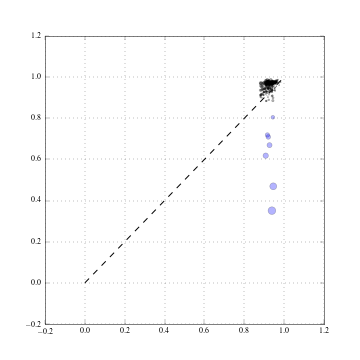

In [71]:
fig1, ax1 = plt.subplots(1,1, figsize=(5,5))
ax1.scatter(df_ratio['calib'], df_ratio['meas'],
            s=df_ratio['ratio']*100, c=df_ratio['color'], alpha=0.3)
ax1.plot([0,1], [0,1], color='k', ls='--')

for label, x, y, z in zip(df_ratio.index, list(df_ratio['calib']), list(df_ratio['meas']), df_ratio['ratio']):
    if z>=1.05:
        ax1.annotate(
            label, 
            xy = (x, y), xytext = (-20, 20),
            textcoords = 'offset points', ha = 'right', va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    
ax1.grid(1)


# EXPLAINING SERVER SIDE TRASHES

In [204]:
df_server_side = df_mock[~df_mock['sIP'].isin(good_sIP)]
df_description = df_server_side.groupby(['sIP', 'domain', 'case'])['port'].count().unstack().fillna(0)
server_blocked = get_ratios(df_description)

In [205]:
print "BAD sIPs trashed = ", len(server_blocked)

BAD sIPs trashed =  128


In [206]:
def getCDF(data):
    xdata = np.sort(data)
    ydata = [i/len(xdata) for i in range(len(xdata))]
    return xdata, ydata

In [207]:
def plot_case_CDF(df, fig1, ax1, dimension='case2'):
    """
    df must contain 3 columns: case1, case2, case3
    df can be indexed by domains, sIP, categs, countries, regions
    """
    x, y = getCDF( list( df[dimension] ) )
    ax1.plot(x, y, color='r', ls='--')
    ax1.grid(1)
    fig1.tight_layout()
    format_axes(ax1)
    return

In [221]:
def plot_scatter_cases(df, fig1, ax1):
    """
    df must contain 3 columns: case1, case2, case3
    df can be indexed by domains, sIP, categs, countries, regions
    """
    
    y = df['case1']+df['case3']
    x = df['case3']/y
    z = 1/df['case2']

    ax1.scatter(x, y, s=z, marker='o', facecolors='none', edgecolors='k')
    ax1.grid(1)
    fig1.tight_layout()
    format_axes(ax1)
    
    return

#fig1.savefig(PLOTS + "calibrating_sIPs_knee")
#fig1.savefig(PLOTS + "calibrating_sIPs_knee.pdf")

<IPython.core.display.Javascript object>


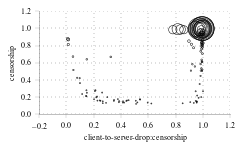

In [225]:
fig1, ax1 = plt.subplots(1,1)
#plot_case_CDF(server_blocked, fig1, ax1, 'case2')
plot_scatter_cases(server_blocked, fig1, ax1)

ax1.set_ylabel("censorship")
ax1.set_xlabel("client-to-server-drop:censorship")
fig1.tight_layout()
format_axes(ax1)

fig1.savefig(PLOTS + "calibration_threshold_sIPs_censorship_technology")
fig1.savefig(PLOTS + "calibration_threshold_sIPs_censorship_technology.pdf")

<IPython.core.display.Javascript object>


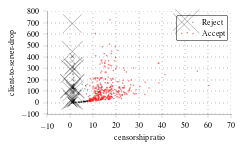

In [214]:
fig1, ax1 = plt.subplots(1,1)

df_server_side = df_mock[~df_mock['sIP'].isin(good_sIP)]
df_description = df_server_side.groupby(['sIP', 'domain', 'case'])['port'].count().unstack().fillna(0)


df = get_ratios(df_description)
y = 1/df['case1']#/(df['case1']+df['case3'])
x = 1/(df['case3']+df['case1']) #df['case1']+df['case3']
z = 1/df['case2']

ax1.scatter(x, y, s=z, marker='x', facecolors='none', edgecolors='k', alpha=0.4, label="Reject")
ax1.grid(1)
fig1.tight_layout()
format_axes(ax1)


df_server_side = df_mock[df_mock['sIP'].isin(good_sIP)]
df_description = df_server_side.groupby(['sIP', 'domain', 'case'])['port'].count().unstack().fillna(0)
df = get_ratios(df_description)

y = 1/df['case1']#/(df['case1']+df['case3'])
x = 1/(df['case3']+df['case1']) #df['case1']+df['case3']
z = 1/df['case2']

ax1.scatter(x, y, s=z, marker='o', facecolors='r', edgecolors='r', alpha=0.4, label="Accept")
ax1.grid(1)
ax1.legend(loc=1)

ax1.set_xlabel("censorship ratio")
ax1.set_ylabel("client-to-server-drop")


fig1.tight_layout()
format_axes(ax1)


fig1.savefig(PLOTS + "calibration_threshold_sIPs_accept_reject")
fig1.savefig(PLOTS + "calibration_threshold_sIPs_accept_reject.pdf")

In [134]:
server_blocked

,case,0,1,2,3,4,tot,err,case1,case2,case3
sIP,domain,,,,,,,,,,
103.6.182.20,agoda.com,63,159,547,42,7,748,70,0.212567,0.731283,0.056150
104.16.5.13,change.org,32,5,4,615,51,624,83,0.008013,0.006410,0.985577
104.16.7.118,petmd.com,44,1,0,589,45,590,89,0.001695,0.000000,0.998305
104.20.12.28,studentdoctor.net,25,2,0,576,40,578,65,0.003460,0.000000,0.996540
104.20.28.30,bungie.net,43,2,1,547,42,550,85,0.003636,0.001818,0.994545
104.20.28.34,tunnelbear.com,27,2,3,628,55,633,82,0.003160,0.004739,0.992101
104.20.5.196,furaffinity.net,15,2,0,438,35,440,50,0.004545,0.000000,0.995455
104.28.7.85,indiansexstories.net,46,4,1,560,47,565,93,0.007080,0.001770,0.991150
107.20.154.40,strava.com,33,253,130,13,9,396,42,0.638889,0.328283,0.032828


In [ ]:
df_client_side = df_mock[df_mock['sIP'].isin(good_sIP)]
df_description = df_server_side.groupby(['sIP', 'domain', 'case'])['port'].count().unstack().fillna(0)
server_blocked = get_ratios(df_description)
plot_scatter_cases(server_blocked, 0).show()